Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import drive

In [2]:
## Mounting google drive to load the data.

drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
cd 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration'

/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration


In [4]:
ls

Test/  Train/


In [5]:
# Defining the path for train and test images.
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


There are 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Seed=123 will be used while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory.
## Images will be resized to the size img_height*img_width.
train_ds = image_dataset_from_directory(
                                        data_dir_train,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = (img_height, img_width),
                                        batch_size = batch_size
                                        )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Seed=123 will be used while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory.
## Images will be resized to the size img_height*img_width.
val_ds = image_dataset_from_directory(
                                        data_dir_train,
                                        validation_split = 0.2,
                                        subset = "validation",
                                        seed = 123,
                                        image_size = (img_height, img_width),
                                        batch_size = batch_size
                                        )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# The classes of skin cancer will be stored in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Visualizing one instance of all the nine classes present in the dataset

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


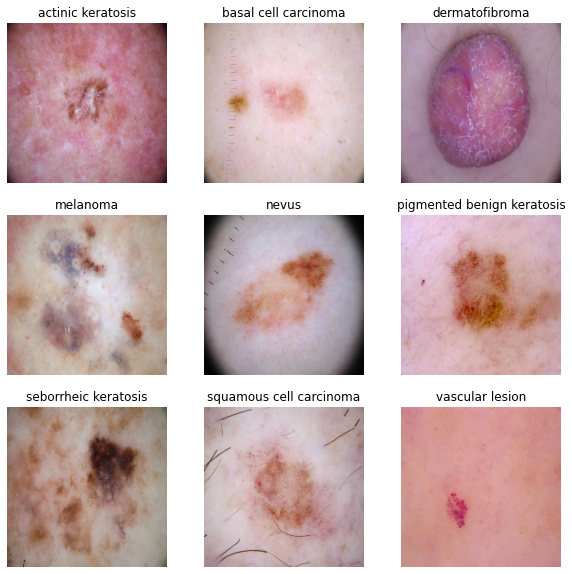

In [11]:
plt.figure(figsize = (10,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
  for images, labels in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(class_names[labels.numpy()[0]])
    plt.axis('off')

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### A CNN model will be created, which can accurately detect 9 classes present in the dataset. ```layers.experimental.preprocessing.Rescaling``` will be used to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                 activation='relu',
                 input_shape=image_batch.shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

### Compiling the model


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.build(input_shape=(batch_size, img_height, img_width, 3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 90, 90, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 90, 90, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 45, 45, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 45, 45, 128)         7

### Training the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 81s 806ms/step - loss: 2.0430 - accuracy: 0.2349 - val_loss: 1.8074 - val_accuracy: 0.3870
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6945 - accuracy: 0.4029 - val_loss: 1.5976 - val_accuracy: 0.4430
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5347 - accuracy: 0.4542 - val_loss: 1.5218 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 3s 46ms/step - loss: 1.4257 - accuracy: 0.5078 - val_loss: 1.3861 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 1.3240 - accuracy: 0.5391 - val_loss: 1.4535 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 3s 49ms/step - loss: 1.3428 - accuracy: 0.5312 - val_loss: 1.3372 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 3s 46ms/step - loss: 1.2136 - accuracy: 0.5670 - val_loss: 1.4843 - val_accuracy: 0.5123
Epoch 8/20
56/56 [====

### Visualizing training results

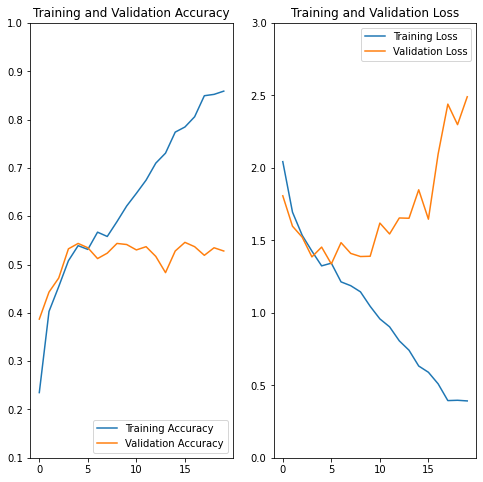

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0.1, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 3)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the graphs plotted above it can be seen that the training  accuracy deviates from the validation accuracy after just a few epochs. The same can be seen with the training and validation loss.

This clearly shows that the model is overfitting on the training data. Therefore steps need to be taken to prevent overfitting of the model, i.e. the model parameters need to be regularized and the images need to be augmented for better results.

### ```RandomRotation``` will be used to augment the images. Lets see how the augmentation looks in one of the images.

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
])

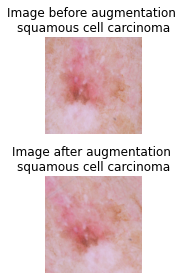

In [20]:
# Visualizing how your augmentation strategy works for one instance of training image.
for image, label in train_ds.take(1):
  plt.subplot(2,1,1)
  plt.imshow(image[0].numpy().astype('uint8'))
  plt.title("Image before augmentation \n"+class_names[label.numpy()[0]])
  plt.axis('off')

  plt.subplot(2,1,2)
  augmented_image = data_augmentation(image[0])
  plt.imshow(augmented_image.numpy().astype('uint8'))
  plt.title("Image after augmentation \n"+class_names[label.numpy()[0]])
  plt.axis('off')

  plt.tight_layout()
  plt.show()

### Creating the model model once again with the above augmentation, compiling and training the model


In [21]:
def prepare(ds):
  ds = ds.map(lambda i, l: (data_augmentation(i), l))
  return ds.prefetch(buffer_size=AUTOTUNE)

augmented_train_ds = prepare(train_ds)
augmented_val_ds = prepare(val_ds)

In [22]:
for image_batch, labels_batch in augmented_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [30]:
## Here, dropout layers will be used as a method of regularization

model = Sequential()
model.add(Rescaling(1./255))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                 activation='relu',
                 input_shape=image_batch.shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))


### Compiling the model

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# View the summary of all layers
model.build(input_shape=(batch_size, img_height, img_width, 3))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 90, 90, 32)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (32, 90, 90, 32)          0         
                                                                 
 conv2d_9 (Conv2D)           (32, 90, 90, 64)          18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 45, 45, 64)         0         
 2D)                                                  

### Training the model

In [33]:
epochs = 30
history = model.fit(
    augmented_train_ds,
    validation_data=augmented_val_ds,
    epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 14s 195ms/step - loss: 2.2239 - accuracy: 0.1942 - val_loss: 2.0971 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - 10s 170ms/step - loss: 2.0431 - accuracy: 0.1830 - val_loss: 2.0463 - val_accuracy: 0.1924
Epoch 3/30
56/56 [==============================] - 11s 191ms/step - loss: 1.9762 - accuracy: 0.2461 - val_loss: 2.0109 - val_accuracy: 0.2461
Epoch 4/30
56/56 [==============================] - 10s 188ms/step - loss: 1.8635 - accuracy: 0.2974 - val_loss: 1.7005 - val_accuracy: 0.3803
Epoch 5/30
56/56 [==============================] - 10s 180ms/step - loss: 1.7065 - accuracy: 0.3638 - val_loss: 1.6106 - val_accuracy: 0.4049
Epoch 6/30
56/56 [==============================] - 10s 180ms/step - loss: 1.7515 - accuracy: 0.3655 - val_loss: 1.6477 - val_accuracy: 0.3982
Epoch 7/30
56/56 [==============================] - 11s 195ms/step - loss: 1.6180 - accuracy: 0.4258 - val_loss: 1.5771 - val_accuracy: 0.4318
Epoch 8/30

### Visualizing the results

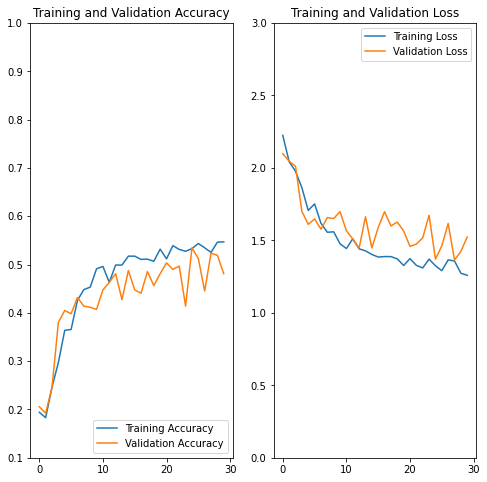

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0.1, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 3)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the newly trained model the training and validation accuracy seems to increase hand in hand. Therefore, the model does not seems to be overfitting anymore due to regularized parameters.

On the otherhand, the accuracy of the model, be it training or validation accuracy seems to be a little above 0.5. This means that the model is now underfitting the data.

#### Lets find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

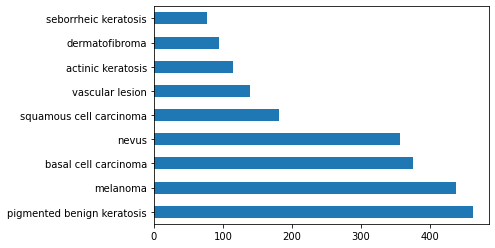

In [36]:
original_df['Label'].value_counts().plot.barh()
plt.show()

#### Findings:
#### - As can be seen above there are certain classes that are underepresented in the data, and others that are over represented.
#### - For example, the class 'seborrheic keratosis' has the least number of samples in the dataset.
#### - The following classes dominate the data in terms proportionate number of samples.

> - pigmented benign keratosis
> - melanoma
> - basal cell carcinoma
> - nevus


#### Rectifying the class imbalance
#### A package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) will be used to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset = data_dir_train

for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F74D823A0>: 100%|██████████| 500/500 [00:30<00:00, 16.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F74E0CD60>: 100%|██████████| 500/500 [00:20<00:00, 23.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F74D94970>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9F74D50C10>: 100%|██████████| 500/500 [01:48<00:00,  4.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F9F74D10FA0>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9F74D0DC70>: 100%|██████████| 500/500 [00:22<00:00, 22.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9F74DBCAC0>: 100%|██████████| 500/500 [00:51<00:00,  9.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9F74D02BB0>: 100%|██████████| 500/500 [00:21<00:00, 23.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9FF2274250>: 100%|██████████| 500/500 [00:22<00:00, 22.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_f91133f5-0a7f-4482-baff-fc0dfada2b00.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_dd4cbdfa-518a-4211-9208-0a2747bc9bf5.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027829.jpg_bf8195fa-df21-46e8-877e-52a6643492af.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026765.jpg_53ddcac2-c943-4b3e-ba82-e6aeb8b79214.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030408.jpg_376c7e98

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [43]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [45]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

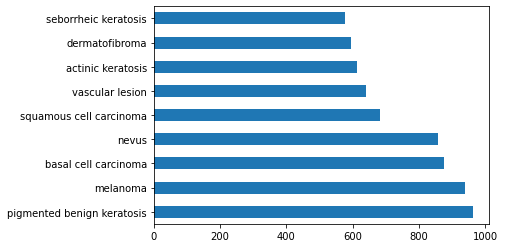

In [46]:
new_df['Label'].value_counts().plot.barh()
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [48]:
data_dir_train=pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [50]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Creating the model alongwith normalization

In [51]:
model = Sequential()

model.add(Rescaling(1./255))


model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                 activation='relu',
                 input_shape=image_batch.shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same',
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))

#### Compiling the model

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# Viewing the summary of all layers
model.build(input_shape=(batch_size, img_height, img_width, 3))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (32, 180, 180, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 180, 180, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 180, 180, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 90, 90, 32)         0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (32, 90, 90, 32)          0         
                                                                 
 conv2d_13 (Conv2D)          (32, 90, 90, 64)         

#### Training the model

In [54]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 [==============================] - 43s 215ms/step - loss: 2.3030 - accuracy: 0.2977 - val_loss: 3.3120 - val_accuracy: 0.1039
Epoch 2/40
169/169 [==============================] - 38s 213ms/step - loss: 1.7537 - accuracy: 0.3895 - val_loss: 2.7954 - val_accuracy: 0.1722
Epoch 3/40
169/169 [==============================] - 38s 214ms/step - loss: 1.5406 - accuracy: 0.4473 - val_loss: 1.6045 - val_accuracy: 0.4024
Epoch 4/40
169/169 [==============================] - 38s 221ms/step - loss: 1.3899 - accuracy: 0.4820 - val_loss: 1.4131 - val_accuracy: 0.4581
Epoch 5/40
169/169 [==============================] - 43s 248ms/step - loss: 1.3034 - accuracy: 0.5247 - val_loss: 1.1661 - val_accuracy: 0.5724
Epoch 6/40
169/169 [==============================] - 38s 219ms/step - loss: 1.1821 - accuracy: 0.5625 - val_loss: 1.2232 - val_accuracy: 0.5575
Epoch 7/40
169/169 [==============================] - 41s 238ms/step - loss: 1.1193 - accuracy: 0.5870 - val_loss: 1.2072 - val_ac

#### Visualizing the model results

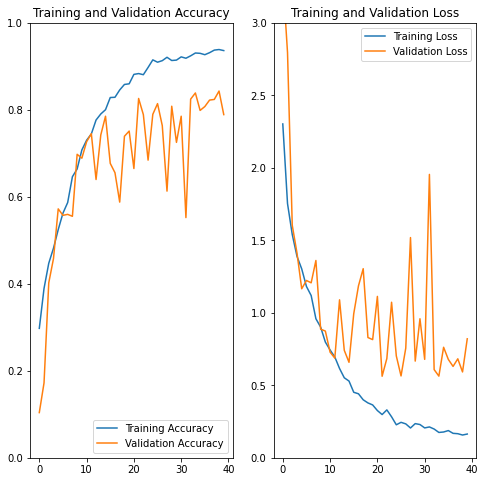

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim(0, 3)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The final model avoids overfitting, since regularization is implemented through dropouts and batch normalization in each layer.
#### The model also performs better in terms of accuracy of its predictions, since the classes have been rebalanced.